In [1]:
import torch
from UNet import UNet
from data import SegmentDataset
from torch.nn import Softmax2d, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import tqdm
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_IMAGES = "dataset/images/"
DATA_MASKS = "dataset/masks/"

IMG_HEIGHT, IMG_WIDTH = 400, 400

BATCH_SZ = 20
EPOCHS = 5

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
all_imgs, all_masks = sorted(glob.glob(DATA_IMAGES+"*")), sorted(glob.glob(DATA_MASKS+"*"))
train_data, test_data = train_test_split(np.array([all_imgs,all_masks]).T,test_size=0.2,random_state=88)

In [5]:
train_data[0]

array(['dataset/images/f1eb080c7182_07.jpg',
       'dataset/masks/f1eb080c7182_07_mask.gif'], dtype='<U38')

In [6]:
trans = transforms.Compose([
 	transforms.Resize((IMG_HEIGHT,IMG_WIDTH)),
	transforms.ToTensor()])

In [7]:
train_dataset = SegmentDataset(train_data[:,0],train_data[:,1],transforms=trans)
test_dataset = SegmentDataset(test_data[:,0],test_data[:,1],transforms=trans)

In [8]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SZ, pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SZ, pin_memory=True)

In [9]:
unet_model = UNet(2).to(device)
lossFunc = CrossEntropyLoss()
opt = Adam(unet_model.parameters(), lr=0.001)
train_steps = len(train_dataset) // BATCH_SZ
test_steps = len(test_dataset) // BATCH_SZ

In [10]:
stats = {"loss train": [], "loss val": []}
for epoch in tqdm.tqdm(range(EPOCHS)):
	unet_model.train()
	totalTrainLoss = 0
	totalTestLoss = 0
	for (i, (x, y)) in enumerate(train_dataloader):
		(x, y) = (x.to(device), y.to(device))
		pred = unet_model(x)
		loss = lossFunc(pred, y)

		opt.zero_grad()
		loss.backward()
		opt.step()
		totalTrainLoss += loss

	with torch.no_grad():
		unet_model.eval()
		for (x, y) in test_dataloader:
			(x, y) = (x.to(device), y.to(device))
			pred = unet_model(x)
			totalTestLoss += lossFunc(pred, y)

	avgTrainLoss = totalTrainLoss / train_steps
	avgTestLoss = totalTestLoss / test_steps
	# update our training history
	stats["loss train"].append(avgTrainLoss.cpu().detach().numpy())
	stats["loss val"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(epoch + 1, EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))

 20%|██        | 1/5 [02:55<11:43, 175.82s/it]

[INFO] EPOCH: 1/5
Train loss: 0.505821, Test loss: 0.5103


 40%|████      | 2/5 [05:51<08:47, 175.75s/it]

[INFO] EPOCH: 2/5
Train loss: 0.474666, Test loss: 0.5077


 60%|██████    | 3/5 [08:48<05:52, 176.22s/it]

[INFO] EPOCH: 3/5
Train loss: 0.507443, Test loss: 0.9268


 80%|████████  | 4/5 [11:44<02:56, 176.18s/it]

[INFO] EPOCH: 4/5
Train loss: 0.467965, Test loss: 0.4703


100%|██████████| 5/5 [14:39<00:00, 175.81s/it]

[INFO] EPOCH: 5/5
Train loss: 0.323257, Test loss: 0.2246


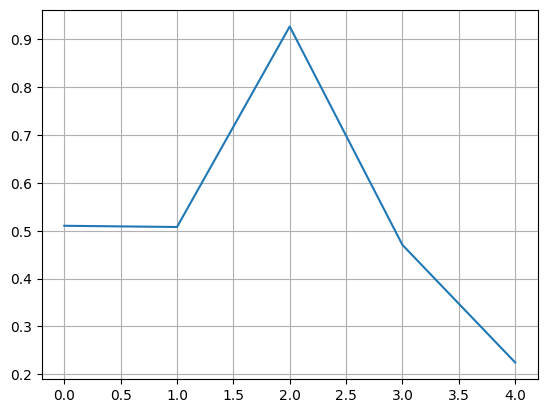

In [11]:
plt.plot(range(EPOCHS),stats["loss val"])
plt.grid(True)

In [12]:
unet_model.eval()

UNet(
  (poolling_list): ModuleList(
    (0-3): 4 x MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stack_1): StackDown(
    (layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
    )
  )
  (stack_2): StackDown(
    (layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
    )
  )
  (stack_3): StackDown(
    (layers): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
    )
  )
  (stack_4): StackDown(
    (layers): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU

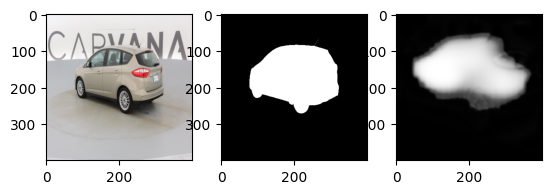

In [42]:
img, mask = test_dataset.__getitem__(20)
pred =unet_model(img.reshape(1,3,IMG_HEIGHT,IMG_WIDTH).to(device)).detach().cpu()
pred_ =  Softmax2d()(pred).numpy().reshape((2,IMG_HEIGHT,IMG_WIDTH))[1]
fig, ax =plt.subplots(1,3)
ax[0].imshow(img.permute((1,2,0)).numpy())
ax[1].imshow(mask.numpy()[1],cmap="gray")
ax[2].imshow(pred_,cmap="gray")

In [44]:
torch.save(unet_model,"saves/weights_5_epochs.pt")